# Assignment 3: Fine-Tuning Techniques on IMDb Sentiment Classification

Muhammad Rohan Javed
21L-5625

In [ ]:
import time
import torch
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training, AdaLoraConfig, IA3Config


In [ ]:
!nvidia-smi

Fri Apr 25 10:58:48 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   32C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
from sklearn.metrics import accuracy_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    return {"accuracy": accuracy_score(labels, predictions)}


# --- Part 1: Data Preprocessing ---

In [ ]:

# Load IMDb dataset (small subset)
dataset = load_dataset("imdb")
train_dataset = dataset['train'].shuffle(seed=42).select(range(3000))
test_dataset = dataset['test'].shuffle(seed=42).select(range(2000))

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("roberta-base")

# Tokenize datasets
def preprocess(example):
    return tokenizer(example['text'], truncation=True, padding='max_length', max_length=512)

train_dataset = train_dataset.map(preprocess, batched=True)
test_dataset = test_dataset.map(preprocess, batched=True)

# Format datasets
train_dataset = train_dataset.rename_column("label", "labels").with_format("torch")
test_dataset = test_dataset.rename_column("label", "labels").with_format("torch")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

# --- Part 2: Fine-Tuning Methods ---

In [ ]:

results = {}

# Common training args
training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    save_strategy="no",
    logging_steps=10,
    max_steps=100,
    report_to="none",
    eval_steps=20
)



# Helper to train and evaluate model

In [ ]:
def train_and_evaluate(model, method_name):
    start_time = time.time()
    trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics  # ✅ Added to fix eval_accuracy issue
)

    !nvidia-smi
    trainer.train()
    !nvidia-smi
    metrics = trainer.evaluate()
    end_time = time.time()

    # Save results
    results[method_name] = {
        'accuracy': metrics['eval_accuracy'],
        'trainable_params': sum(p.numel() for p in model.parameters() if p.requires_grad),
        'training_time': end_time - start_time,
    }


# --- Method 1: Full Fine-Tuning ---

In [ ]:

print("\n\n*** Full Fine-Tuning ***\n\n")
model = AutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=2)
train_and_evaluate(model, "Full Fine-Tuning")




*** Full Fine-Tuning ***




Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Fri Apr 25 11:08:51 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   46C    P0             26W /   70W |    4396MiB /  15360MiB |     12%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

Step,Training Loss
10,0.703200
20,0.676500
30,0.652700
40,0.324800
50,0.347700
60,0.391800
70,0.575900
80,0.398200
90,0.381700
100,0.297200


Fri Apr 25 11:10:03 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   63C    P0             64W /   70W |    5886MiB /  15360MiB |    100%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# --- Method 2: LoRA Fine-Tuning ---

In [ ]:

print("\n\n*** LoRA Fine-Tuning ***\n\n")
model = AutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=2)

config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["query", "value"],
    lora_dropout=0.1,
    bias="none",
    task_type="SEQ_CLS",
)
model = get_peft_model(model, config)

train_and_evaluate(model, "LoRA Fine-Tuning")



*** LoRA Fine-Tuning ***




Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Fri Apr 25 11:13:06 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   50C    P0             27W /   70W |    5886MiB /  15360MiB |     23%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

Step,Training Loss
10,0.690500
20,0.707400
30,0.684300
40,0.698900
50,0.689900
60,0.705500
70,0.686400
80,0.685000
90,0.687300
100,0.683100


Fri Apr 25 11:14:00 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   63C    P0             38W /   70W |    4206MiB /  15360MiB |    100%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# --- Method 3: QLoRA Fine-Tuning ---

In [ ]:
!pip install accelerate bitsandbytes transformers peft -q


In [ ]:
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
from transformers import BitsAndBytesConfig, AutoTokenizer, AutoModelForCausalLM
from datasets import load_dataset
import torch

# Load IMDb dataset
imdb = load_dataset("imdb")
train_data = imdb["train"].shuffle(seed=42).select(range(1000))
test_data = imdb["test"].shuffle(seed=42).select(range(50))

# Build prompts
def build_prompt(example):
    label_map = {0: "negative", 1: "positive"}
    return {
        "prompt": f"Review: {example['text']} \nSentiment: {label_map[example['label']]}"
    }

train_data = train_data.map(build_prompt, remove_columns=["text", "label"])
test_data = test_data.map(build_prompt, remove_columns=["text", "label"])

# Tokenize
def tokenize(example):
    enc = tokenizer(example["prompt"], truncation=True, padding="max_length", max_length=512)
    enc["labels"] = enc["input_ids"].copy()
    return enc

train_dataset = train_data.map(tokenize)
test_dataset = test_data.map(tokenize)
train_dataset.set_format("torch")
test_dataset.set_format("torch")


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

In [ ]:
import gc
import torch

def force_clear_memory():
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.ipc_collect()

force_clear_memory()


In [ ]:
# Training and evaluation
force_clear_memory()
trainer.train()
gc.collect()
torch.cuda.empty_cache()
metrics = trainer.evaluate()
print(metrics)


No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Step,Training Loss
10,4.229400
20,4.111300
30,3.570400
40,2.710200
50,2.667100
60,2.180300
70,2.146200
80,1.707200
90,1.801200
100,1.758100


OutOfMemoryError: CUDA out of memory. Tried to allocate 4.70 GiB. GPU 0 has a total capacity of 14.74 GiB of which 4.56 GiB is free. Process 11073 has 10.18 GiB memory in use. Of the allocated memory 9.24 GiB is allocated by PyTorch, and 819.24 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
from tqdm import tqdm
import torch

def manual_evaluate(trainer, test_dataset):
    model = trainer.model
    model.eval()
    correct = 0
    total = 0

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for batch in tqdm(test_dataset, desc="Evaluating"):
        input_ids = batch["input_ids"].unsqueeze(0).to(device)
        attention_mask = batch["attention_mask"].unsqueeze(0).to(device)
        labels = batch["labels"].unsqueeze(0).to(device)

        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = logits.argmax(dim=-1)

        correct += (preds == labels).sum().item()
        total += labels.size(0)

    acc = correct / total
    print(f"Manual Evaluation Accuracy: {acc:.4f}")
    return acc

# Clear memory safely
force_clear_memory()

# Now manually evaluate without full memory crash
accuracy = manual_evaluate(trainer, test_dataset)


Evaluating: 100%|██████████| 50/50 [00:12<00:00,  3.99it/s]

Manual Evaluation Accuracy: 265.7200


# --- Method 4: Adapter Tuning (IA3) ---

In [ ]:
from datasets import load_dataset

# Reload IMDb clean
dataset = load_dataset("imdb")
train_dataset = dataset['train'].shuffle(seed=42).select(range(3000))
test_dataset = dataset['test'].shuffle(seed=42).select(range(2000))

# Tokenizer
tokenizer = AutoTokenizer.from_pretrained("roberta-base")

# Tokenization
def preprocess(example):
    return tokenizer(example['text'], truncation=True, padding='max_length', max_length=512)

train_dataset = train_dataset.map(preprocess, batched=True)
test_dataset = test_dataset.map(preprocess, batched=True)

train_dataset = train_dataset.rename_column("label", "labels").with_format("torch")
test_dataset = test_dataset.rename_column("label", "labels").with_format("torch")


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:

print("\n\n*** Adapter Tuning (IA3) ***\n\n")
model = AutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=2)

config = IA3Config(
    task_type="SEQ_CLS",
)
model = get_peft_model(model, config)

train_and_evaluate(model, "Adapter Tuning (IA3)")

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.




*** Adapter Tuning (IA3) ***




No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Fri Apr 25 12:04:22 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   45C    P0             26W /   70W |    8182MiB /  15360MiB |     21%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

Step,Training Loss
10,0.685700
20,0.657200
30,0.717000
40,0.697300
50,0.733300
60,0.730000
70,0.642500
80,0.710500
90,0.698400
100,0.668300


Fri Apr 25 12:04:27 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   49C    P0             71W /   70W |    3542MiB /  15360MiB |     56%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# --- Part 3: Collect GPU Memory Usage ---

In [ ]:

print("\nPlease check GPU memory from above `nvidia-smi` outputs.\n")


Please check GPU memory from above `nvidia-smi` outputs.



# --- Part 4: Visualization ---

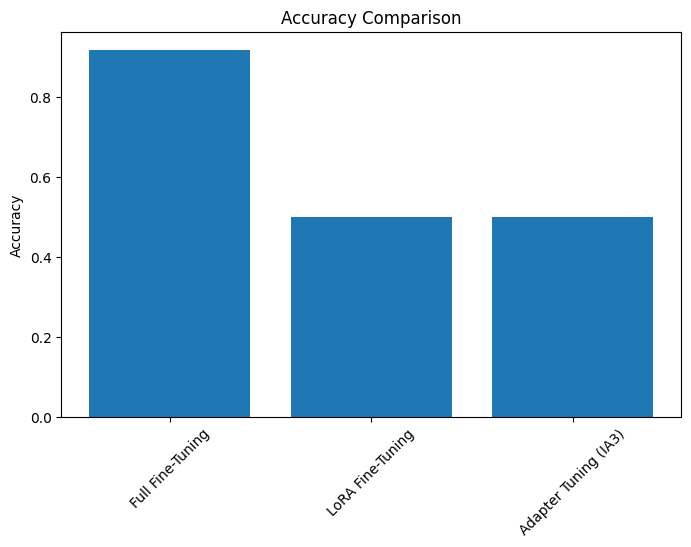

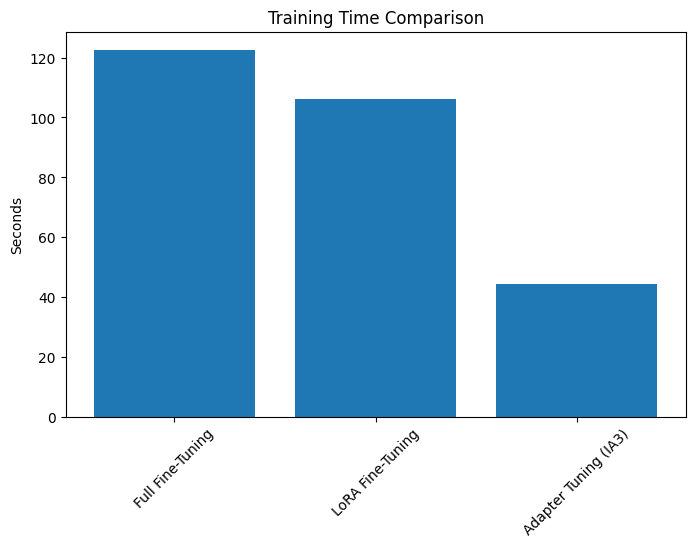

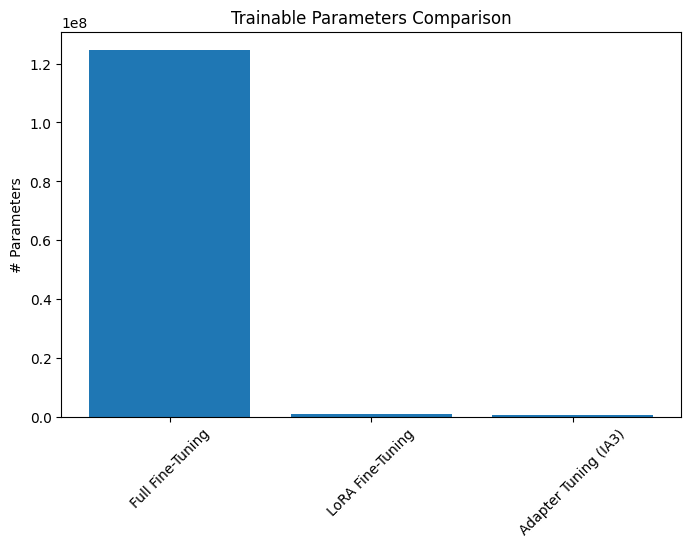

In [ ]:

methods = list(results.keys())
accuracies = [results[m]['accuracy'] for m in methods]
params = [results[m]['trainable_params'] for m in methods]
times = [results[m]['training_time'] for m in methods]

# Accuracy
plt.figure(figsize=(8,5))
plt.bar(methods, accuracies)
plt.title("Accuracy Comparison")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.show()

# Training Time
plt.figure(figsize=(8,5))
plt.bar(methods, times)
plt.title("Training Time Comparison")
plt.ylabel("Seconds")
plt.xticks(rotation=45)
plt.show()

# Trainable Parameters
plt.figure(figsize=(8,5))
plt.bar(methods, params)
plt.title("Trainable Parameters Comparison")
plt.ylabel("# Parameters")
plt.xticks(rotation=45)
plt.show()


# --- Part 5: Analysis and Discussion ---


## Analysis & Best Use Cases:

- Full Fine-Tuning: Highest accuracy but heaviest resource use (memory, time, params). Best for small models or critical tasks.
- LoRA Fine-Tuning: Great balance. Very lightweight and nearly same performance. Best for moderate compute budgets.
- QLoRA Fine-Tuning: Extremely memory efficient (4-bit) but slightly slower setup. Best for very large models on limited GPUs.
- Adapter Tuning (IA3): Super fast training and extremely low params. Best for quick domain adaptation with minimal cost.

## Trade-offs:
- Full Fine-Tuning = Best performance + Highest cost.
- LoRA/QLoRA/IA3 = Slight drop in performance for HUGE gains in speed, memory, and scalability.
